## Working with Text Data

In Chapter 4, we talked about two kinds of features that can represent properties of the data: continuous features that describe a quantity, and categorical features that are items from a fixed list. There is a third kind of feature that can be found in many applications, which is text. 

For example, if we want to classify an email message as either a legitimate email or spam, the content of the email will certainly contain important information for this classification task. 

Or maybe we want to learn about the opinion of a politician on the topic of immigration. Here, that individual’s speeches or tweets might provide useful information. 

In customer service, we often want to find out if a message is a complaint or an inquiry. We can use the subject line and content of a message to automatically determine the customer’s intent, which allows us to send the message to the appropriate department, or even send a fully automatic reply.

Text data is usually represented as strings, made up of characters. In any of the examples just given, the length of the text data will vary. This feature is clearly very different from the numeric features that we’ve discussed so far, and we will need to process the data before we can apply our machine learning algorithms to it.

### Types of Data Represented as Strings

Before we dive into the processing steps that go into representing text data for machine learning, we want to briefly discuss different kinds of text data that you might encounter. Text is usually just a string in your dataset, but not all string features should be treated as text. A string feature can sometimes represent categorical variables, as we discussed in Chapter 5. There is no way to know how to treat a string feature before looking at the data.

There are four kinds of string data you might see:
- Categorical data
- Free strings that can be semantically mapped to categories
- Structured string data
- Text data

*Categorical data* is data that comes from a fixed list. Say you collect data via a survey where you ask people their favorite color, with a drop-down menu that allows them to select from “red,” “green,” “blue,” “yellow,” “black,” “white,” “purple,” and “pink.” This will result in a dataset with exactly eight different possible values, which clearly encode a categorical variable.  You can check whether this is the case for your data by eyeballing it (if you see very many different strings it is unlikely that this is a categorical variable) and confirm it by computing the unique values over the dataset, and possibly a histogram over how often each appears. You also might want to check whether each variable actually corresponds to a category that makes sense for your application. Maybe halfway through the existence of your survey, someone found that “black” was misspelled as “blak” and subsequently fixed the survey. As a result, your dataset contains both “blak” and “black,” which correspond to the same semantic meaning and should be consolidated.

Now imagine instead of providing a drop-down menu, you provide a text field for the users to provide their own favorite colors. Many people might respond with a color name like “black” or “blue.” Others might make typographical errors, use different spellings like “gray” and “grey,” or use more evocative and specific names like “midnight blue.” You will also have some very strange entries. Some good examples come from the xkcd Color Survey, where people had to name colors and came up with names like “velociraptor cloaka” and “my dentist’s office orange. I still remember his dandruff slowly wafting into my gaping yaw,” which are hard to map to colors automatically (or at all). The responses you can obtain from a text field belong to the second category in the list, *free strings that can be semantically mapped to categories*. It will probably be best to encode this data as a categorical variable, where you can select the categories either by using the most common entries, or by defining categories that will capture responses in a way that makes sense for your application. You might then have some categories for standard colors, maybe a category “multicolored” for people that gave answers like “green and red stripes,” and an “other” category for things that cannot be encoded otherwise. This kind of preprocessing of strings can take a lot of manual effort and is not easily automated. If you are in a position where you can influence data collection, we highly recommend avoiding manually entered values for concepts that are better captured using categorical variables.

Often, manually entered values do not correspond to fixed categories, but still have some underlying *structure*, like addresses, names of places or people, dates, telephone numbers, or other identifiers. These kinds of strings are often very hard to parse, and their treatment is highly dependent on context and domain. A systematic treatment of these cases is beyond the scope of this book.

The final category of string data is freeform *text data* that consists of phrases or sentences. Examples include tweets, chat logs, and hotel reviews, as well as the collected works of Shakespeare, the content of Wikipedia, or the Project Gutenberg collection of 50,000 ebooks. All of these collections contain information mostly as sentences composed of words.  For simplicity’s sake, let’s assume all our documents are in one language, English.  In the context of text analysis, the dataset is often called the *corpus*, and each data point, represented as a single text, is called a *document*. These terms come from the *information retrieval (IR)* and *natural language processing (NLP)* community, which both deal mostly in text data.

### Example Application - Sentient Analysis of Movie Reviews

As a running example in this chapter, we will use a dataset of movie reviews from the IMDb (Internet Movie Database) website collected by Stanford researcher Andrew Maas.  This dataset contains the text of the reviews, together with a label that indicates whether a review is “positive” or “negative.” The IMDb website itself contains ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a two-class classification dataset where reviews with a score of 7 or higher are labeled as positive, and a score 4 or lower is labeled as negative (neutral reviews are not included in the dataset). We will leave the question of whether this is a good representation of the data open, and simply use the data as provided by Andrew Maas. 

In [1]:
!tree -dL 2 data/aclImdb

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


After unpacking the data, the data set is provided as text files in two separate folders, one for the training data, and one for the test data. Each of these in turn has two sub-folders, one called “positive” and one called “negative”.

The *pos* folder contains all the positive reviews, each as a separate text file, and similarly for the *neg* folder.

There is a helper function in scikit-learn to load files stored in such a folder structure, where each subfolder corresponds to a label, called *load_files*. We apply the *load_files* function first to the training data:

In [2]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")

# Load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target

print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


You can see that *text_train* is a list of length 25,000, where each entry is a string containing a review. We printed the review with index 1. You can also see that the review contains some HTML line breaks `(<br />)`. While these are unlikely to have a large impact on our machine learning models, it is better to clean the data and remove this formatting before we proceed:

In [3]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

The type of the entries of *text_train* will depend on your Python version. In Python 3, they will be of type bytes which represents a binary encoding of the string data. In Python 2, *text_train* contains strings. We won’t go into the details of the different string types in Python here, but we recommend that you read the Python 2 and/or Python 3 documentation regarding strings and Unicode.

The dataset was collected such that the positive class and the negative class balanced, so that there are as many positive as negative strings:

In [4]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


We load the test dataset in the same manner:

In [6]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


The task we want to solve is as follows: given a review, we want to assign the label “positive” or “negative” based on the text content of the review. This is a standard binary classification task. However, the text data is not in a format that a machine learning model can handle. We need to convert the string representation of the text into a numeric representation that we can apply our machine learning algorithms to.

### Representing Text Data as a Bag of Words

One of the most simple but effective and commonly used ways to represent text for machine learning is using the *bag-of-words* representation. When using this representation, we discard most of the structure of the input text, like chapters, paragraphs, sentences, and formatting, and only count *how often each word appears in each text* in the corpus. Discarding the structure and counting only word occurrences leads to the mental image of representing text as a “bag.”

Computing the bag-of-words representation for a corpus of documents consists of the following three steps:

1. *Tokenization*. Split each document into the words that appear in it (called tokens), for example by splitting them on whitespace and punctuation.

2. *Vocabulary building*. Collect a vocabulary of all words that appear in any of the documents, and number them (say, in alphabetical order).

3. *Encoding*. For each document, count how often each of the words in the vocabulary appear in this document.

There are some subtleties involved in step 1 and step 2, which we will discuss in more detail later in this chapter. For now, let’s look at how we can apply the bag-of-words processing using scikit-learn. Here we illustrate the process on the string "*This is how you get ants.*".

The output is one vector of word counts for each document. For each word in the vocabulary, we have a count of how often it appears in each document. That means our numeric representation has one feature for each unique word in the whole dataset. Note how the order of the words in the original string is completely irrelevant to the bag-of-words feature representation.

`"This is how you get ants."
             |   Tokenizer
             v
['this', 'is', 'how', 'you', 'get', 'ants']
             |   Build a vocabulary over all documents
             v
['aardvark', 'amsterdam', 'ants', ..., 'you', 'your', 'zyxst']
             |
             v   Sparse matrix encoding
aardvark   ants         get           you      zyxst
[0, ... ,0, 1, 0, ... 0, 1, 0, ..., 0, 1, 0, ..., 0]`

### Applying Bag-of-Words to a Toy Dataset

The bag-of-words representation is implemented in *CountVectorizer*, which is a transformer. Let’s first apply it to a toy dataset, consisting of two samples, to see it working:

In [7]:
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

We import and instantiate the *CountVectorizer* and fit it to our toy data as follows:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Fitting the *CountVectorizer* consists of the tokenization of the training data and building of the vocabulary, which we can access as the *vocabulary_* attribute:

In [9]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content: {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content: {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


The vocabulary consists of 13 words, from "be" to "wise".

To create the bag-of-words representation for the training data, we call the *transform* method:

In [10]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


The bag-of-words representation is stored in a SciPy sparse matrix that only stores the entries that are nonzero. The matrix is of shape 2×13, with one row for each of the two data points and one feature for each of the words in the vocabulary. A sparse matrix is used as most documents only contain a small subset of the words in the vocabulary, meaning most entries in the feature array are 0. 

Think about how many different words might appear in a movie review compared to all the words in the English language (which is what the vocabulary models). Storing all those zeros would be prohibitive, and a waste of memory. To look at the actual content of the sparse matrix, we can convert it to a “dense” NumPy array (that also stores all the 0 entries) using the toarray method:

In [11]:
print("Dense representation of bag_of_words:\n{}".format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


We can see that the word counts for each word are either 0 or 1; neither of the two strings in *bards_words* contains a word twice. 

Let’s take a look at how to read these feature vectors. The first string ("The fool doth think he is wise,") is represented as the first row in, and it contains the first word in the vocabulary, "*be*", zero times. It also contains the second word in the vocabulary, "*but*", zero times. It contains the third word, "*doth*", once, and so on. Looking at both rows, we can see that the fourth word, "*fool*", the tenth word, "*the*", and the thirteenth word, "*wise*", appear in both strings.

### Bag-of-Words for Movie Reviews

Now that we’ve gone through the bag-of-words process in detail, let’s apply it to our task of sentiment analysis for movie reviews. Earlier, we loaded our training and test data from the IMDb reviews into lists of strings (*text_train* and *text_test*), which we will now process:

In [12]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


The shape of *X_train*, the bag-of-words representation of the training data, is 25,000×74,849, indicating that the vocabulary contains 74,849 entries. Again, the data is stored as a SciPy sparse matrix. 

Let’s look at the vocabulary in a bit more detail. Another way to access the vocabulary is using the *get_feature_name* method of the vectorizer, which returns a convenient list where each entry corresponds to one feature:

In [13]:
feature_names = vect.get_feature_names()

print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


As you can see, possibly a bit surprisingly, the first 10 entries in the vocabulary are all numbers. All these numbers appear somewhere in the reviews, and are therefore extracted as words. Most of these numbers don’t have any immediate semantic meaning—apart from "007", which in the particular context of movies is likely to refer to the James Bond character.

Weeding out the meaningful from the nonmeaningful “words” is sometimes tricky. Looking further along in the vocabulary, we find a collection of English words starting with “dra”. You might notice that for "draught", "drawback", and "drawer" both the singular and plural forms are contained in the vocabulary as distinct words. These words have very closely related semantic meanings, and counting them as different words, corresponding to different features, might not be ideal.

Before we try to improve our feature extraction, let’s obtain a quantitative measure of performance by actually building a classifier. We have the training labels stored in *y_train* and the bag-of-words representation of the training data in *X_train*, so we can train a classifier on this data. For high-dimensional, sparse data like this, linear models like *LogisticRegression* often work best.

Let’s start by evaluating *LogisticRegression* using cross-validation:

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


We obtain a mean cross-validation score of 88%, which indicates reasonable performance for a balanced binary classification task. We know that *LogisticRegression* has a regularization parameter, C, which we can tune via cross-validation:

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


We obtain a cross-validation score of 89% using *C=0.1*. We can now assess the generalization performance of this parameter setting on the test set:

In [16]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.88


Now, let’s see if we can improve the extraction of words. The CountVectorizer extracts tokens using a regular expression. By default, the regular expression that is used is "\b\w\w+\b". If you are not familiar with regular expressions, this means it finds all sequences of characters that consist of at least two letters or numbers (\w) and that are separated by word boundaries (\b). It does not find single-letter words, and it splits up contractions like “doesn’t” or “bit.ly”, but it matches “h8ter” as a single word. 

The *CountVectorizer* then converts all words to lowercase characters, so that “soon”, “Soon”, and “sOon” all correspond to the same token (and therefore feature). This simple mechanism works quite well in practice, but as we saw earlier, we get many uninformative features (like the numbers). 

One way to cut back on these is to only use tokens that appear in at least two documents (or at least five documents, and so on). A token that appears only in a single document is unlikely to appear in the test set and is therefore not helpful. We can set the minimum number of documents a token needs to appear in with the *min_df* parameter:

In [17]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)

print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


By requiring at least five appearances of each token, we can bring down the number of features to 27,271, as seen in the preceding output—only about a third of the original features. 

Let’s look at some tokens again:

In [18]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

There are clearly many fewer numbers, and some of the more obscure words or misspellings seem to have vanished. Let’s see how well our model performs by doing a grid search again:

In [19]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


The best validation accuracy of the grid search is still 89%, unchanged from before. We didn’t improve our model, but having fewer features to deal with speeds up processing and throwing away useless features might make the model more interpretable.

#### Note

If the *transform* method of *CountVectorizer* is called on a document that contains words that were not contained in the training data, these words will be ignored as they are not part of the dictionary. This is usually not really an issue for classification, as it’s not possible to learn anything about words that are not in the training data. 

For some applications, like spam detection, it might be helpful to add a feature that encodes how many so-called “out of vocabulary” words there are in a particular document, though. This is not implemented in scikit-learn for now, but it’s not that hard to write yourself. You need to be sure to restrict the vocabulary in some way; otherwise, no words will be “out of vocabulary” during training.

### Stopwords

Another way that we can get rid of uninformative words is by discarding words that are too frequent to be informative. There are two main approaches: using a language-specific list of stopwords, or discarding words that appear too frequently. scikit-learn has a built-in list of English stopwords in the *feature_extraction.text* module:

In [20]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['as', 'might', 'along', 'four', 'are', 'besides', 'became', 'although', 'she', 'eg', 'afterwards', 'thereafter', 'describe', 'be', 'to', 'up', 'con', 'hereby', 'except', 'part', 'own', 'hereafter', 'while', 'becoming', 'fifteen', 'two', 'toward', 'from', 'cannot', 'noone', 'after', 'ever']


Clearly, removing the stopwords in the list can only decrease the number of features by the length of the list—here, 318—but it might lead to an improvement in performance. 

Let’s give it a try:

In [21]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)

print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


There are now 305 (27,271–26,966) fewer features in the dataset, which means that most, but not all, of the stopwords appeared. 

Let’s run the grid search again:

In [22]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


The grid search performance decreased slightly using the stopwords—not enough to worry about, but given that excluding 305 features out of over 27,000 is unlikely to change performance or interpretability a lot, it doesn’t seem worth using this list. 

Fixed lists are mostly helpful for small datasets, which might not contain enough information for the model to determine which words are stopwords from the data itself. As an exercise, you can try out the other approach, discarding frequently appearing words, by setting the *max_df* option of *CountVectorizer* and see how it influences the number of features and the performance.

### Rescaling the Data with tf-idf

Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the *term frequency–inverse document frequency (tf–idf)* method. The intuition of this method is to give high weight to any term that appears often in a particular document, but not in many documents in the corpus. 

If a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document. scikit-learn implements the tf–idf method in two classes: *TfidfTransformer*, which takes in the sparse matrix output produced by *CountVectorizer* and transforms it, and *TfidfVectorizer*, which takes in the text data and does both the bag-of-words feature extraction and the tf–idf transformation. 

There are several variants of the tf–idf rescaling scheme, which you can read about on Wikipedia. The tf–idf score for word w in document d as implemented in both the *TfidfTransformer* and *TfidfVectorizer* classes is given by:

tfidf(w, d) = tf * log ($\frac{N + 1}{N_{w} + 1}$) + 1

where 
- N is the number of documents in the training set
- Nw is the number of documents in the training set that the word w appears in
- tf (the term frequency) is the number of times that the word w appears in the query document d (the document you want to transform or encode) 

Both classes also apply L2 normalization after computing the tf–idf representation; in other words, they rescale the representation of each document to have Euclidean length 1.  Rescaling in this way means that the length of a document (the number of words) does not change the vectorized representation.

Because tf–idf actually makes use of the statistical properties of the training data, we will use a pipeline, as described in Chapter 6, to ensure the results of our grid search are valid. 

This leads to the following code:

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


In this case, tf–idf had no impact. We can also inspect which words tf–idf found most important. Keep in mind that the tf–idf scaling is meant to find words that distinguish documents, but it is a purely unsupervised technique. So, “important” here does not necessarily relate to the “positive review” and “negative review” labels we are interested in. 

First, we extract the TfidfVectorizer from the pipeline:

In [24]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

# Transform the training dataset
X_train = vectorizer.transform(text_train)

# Find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# Get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
Features with highest tfidf: 
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


Features with low tf–idf are those that either are very commonly used across documents or are only used sparingly, and only in very long documents. Interestingly, many of the high-tf–idf features actually identify certain shows or movies. These terms only appear in reviews for this particular show or franchise, but tend to appear very often in these particular reviews. This is very clear, for example, for "homer", "timon", and "titanic". 

These words are unlikely to help us in our sentiment classification task (unless maybe some franchises are universally reviewed positively or negatively) but certainly contain a lot of specific information about the reviews.

We can also find the words that have low inverse document frequency—that is, those that appear frequently and are therefore deemed less important. The inverse document frequency values found on the training set are stored in the idf_ attribute:

In [25]:
sorted_by_idf = np.argsort(vectorizer.idf_)

print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


As expected, these are mostly English stopwords like "the" and "no". But some are clearly domain-specific to the movie reviews, like "movie", "film", "time", "story", and so on. Interestingly, "good", "great", and "bad" are also among the most frequent and therefore “least relevant” words according to the tf–idf measure, even though we might expect these to be very important for our sentiment analysis task.

### Investigating Model Coefficients

Finally, let’s look in a bit more detail into what our logistic regression model actually learned from the data. Because there are so many features—27,271 after removing the infrequent ones—we clearly cannot look at all of the coefficients at the same time. 

However, we can look at the largest coefficients, and see which words these correspond to. We will use the last model that we trained, based on the tf–idf features.

The following bar chart shows the 25 largest and 25 smallest coefficients of the logistic regression model, with the bars showing the size of each coefficient:

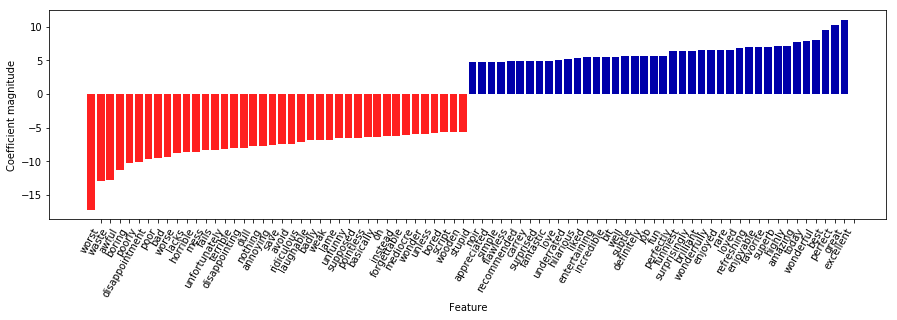

In [26]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

The negative coefficients on the left belong to words that according to the model are indicative of negative reviews, while the positive coefficients on the right belong to words that according to the model indicate positive reviews. Most of the terms are quite intuitive, like "worst", "waste", "disappointment", and "laughable" indicating bad movie reviews, while "excellent", "wonderful", "enjoyable", and "refreshing" indicate positive movie reviews. Some words are slightly less clear, like "bit", "job", and "today", but these might be part of phrases like “good job” or “best today.”